# RDS Homework 2 Template
## Spring 2024


In [49]:
!pip install shap

In [50]:
from __future__ import print_function

import shap
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kojil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Problem 3

### Part (A)

In [51]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']

In [52]:
# Initialize & fit tf-idf vectorizer
vectorizer = TfidfVectorizer()
train = vectorizer.fit_transform(newsgroups_train.data)
test = vectorizer.transform(newsgroups_test.data)


In [53]:
# Train a SGDClassifier
clf = SGDClassifier()
clf.fit(train, newsgroups_train.target)

SGDClassifier()

### Part (B)

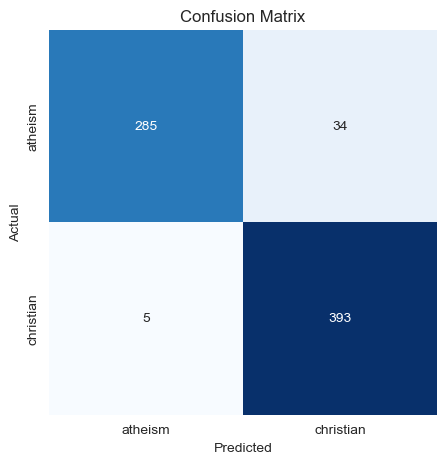

In [54]:
# Confusion Matrix
pred = clf.predict(test)
cm = sklearn.metrics.confusion_matrix(newsgroups_test.target, pred)
# Show confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Explainer

In [55]:
# Initialize the linear explainer and apply to test data
explainer = shap.LinearExplainer(clf, train, feature_pertubation="interventional")
shap_values = explainer.shap_values(test)


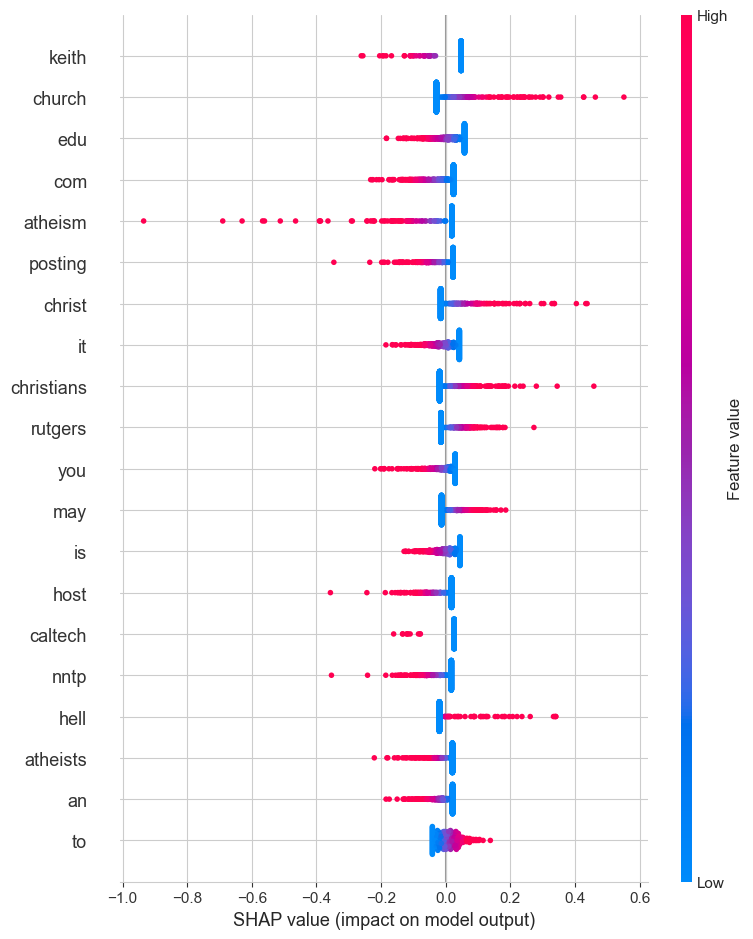

In [57]:
# Select 5 documents in the test set for explanation
X_test_array = test.toarray()
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names_out())

In [63]:
# Visually explain 5 documents selected from the test set
shap.initjs()
correctly_classified = np.where(pred == newsgroups_test.target)[0]
misclassified = np.where(pred != newsgroups_test.target)[0]
correctly_classified = np.random.choice(correctly_classified, 3)
misclassified = np.random.choice(misclassified, 2)
selected_docs = np.concatenate([correctly_classified, misclassified])
for doc_id in selected_docs:
    #print(f"Document ID: {doc_id}")
    #print(f"Predicted class: {class_names[pred[doc_id]]}")
    #print(f"Actual class: {class_names[newsgroups_test.target[doc_id]]}")
    #print("Atheism" if newsgroups_test.target[doc_id] else "Negative", "Review:")
    #print(newsgroups_test[doc_id])
    shap.force_plot(explainer.expected_value, shap_values[doc_id,:], X_test_array[doc_id,:],feature_names=vectorizer.get_feature_names_out())
    plt.show()


### Part (C)


#### Part (i)

In [ ]:
# Compute the accuracy of the classifier and the number of misclassified documents
accuracy = np.mean(pred == newsgroups_test.target)
print("Accuracy: {}".format(accuracy))
print("Number of misclassified documents: {}".format(np.sum(pred != newsgroups_test.target)))

#### Part (ii)

In [ ]:
# Calculate conf_i for all misclassified documents

probabilities = clf.predict_proba(X_test)
conf = np.abs(probabilities[:, 0] - probabilities[:, 1])
misclassified_indices = np.where(pred != newsgroups_test.target)[0]
conf_misclassified = conf[misclassified_indices]

In [ ]:
# Plot conf_i

plt.figure(figsize=(10,5))
plt.hist(conf_misclassified, bins=20, color='blue', alpha=0.7)
plt.xlabel('conf_i')
plt.ylabel('Frequency')
plt.title('Distribution of errors')
plt.show()

#### Part (iii)

In [ ]:
# Identify tokens (word_j) that contributed to the misclassification of documents

count_dict = defaultdict(int)
weight_dict = defaultdict(float)

for i in misclassified_indices:
    shap_values_i = shap_values[i]
    for j in range(len(shap_values_i)):
        if shap_values_i[j] != 0:
            count_dict[j] += 1
            weight_dict[j] += np.abs(shap_values_i[j])

In [ ]:
# Plot the distribution of count_j
plt.figure(figsize=(10,5))
plt.hist(count_dict.values(), bins=20, color='blue', alpha=0.7)
plt.xlabel('count_j')
plt.ylabel('Frequency')
plt.title('Distribution of count_j')
plt.show()

In [ ]:
# Plot the distribution of weight_j
plt.figure(figsize=(10,5))
plt.hist(weight_dict.values(), bins=20, color='blue', alpha=0.7)
plt.xlabel('weight_j')
plt.ylabel('Frequency')
plt.title('Distribution of weight_j')
plt.show()

### Part (D)

In [ ]:
# Implement a strategy for feature selection

In [ ]:
# Identify at least one example that was misclassified before feature selection and that is classified correctly after feature selection